In [100]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import casadi as ca
from utils import *
from plot_utils import *

opti = ca.Opti()

# discrete time horizon length
N = 70

# continuous dynamics
ns = 3              # state space dimension
na = 1              # action space dimension

#T = opti.variable(1,N)
#T_h = opti.variable(1,N)
#T_out = opti.variable(1,N)
x = opti.variable(3,N+1)
u = opti.variable(1,N) #control variable

# ----- Define model parameters -----
C = 9.57 # [kJ/C]
C_h = 0.134 # [kJ/C]
Rih = 2.151 #[C h /kW]
Ria = 2 #[C h /kW]
R_fr = 2.030 #[C h /kW]
T_in = 60 #C
c_pw =  4.182 # specific heat capacity of the water in the radiatior [kJ/(kg * K)]
T_amb = 6


# System dynamic
f = Function('f',[x,u],[1/C * ( 1/Rih * (x[1] - x[0]) + 1/Ria * (T_amb - x[0]) ), 1/C_h * ( u*c_pw * (T_in - x[1]) + 1/Rih * (x[0] - x[1]) ), 1/C_h * (  1/R_fr * (x[1] - x[2]))])


In [101]:
# cost
T_set = 20 #set point

terminal_cost = Function('terminal_cost', [x], [5 * (T_set - x[0])**2])

cost = 0
for i in range(N+1):
    cost += (T_set - x[0,i])**2

opti.minimize( cost )

dt = 0.05
n_steps = 1

# Runge-Kutta integration
def RK4(x, u, f, dt, N_steps=1):

    h = dt/N_steps

    for _ in range(N_steps):

        k_1 = f(x, u)
        k_2 = f(x + 0.5 * h * k_1, u) 
        k_3 = f(x + 0.5 * h * k_2, u)
        k_4 = f(x + k_3 * h, u)

        x_next = x + (1/6) * (k_1 + 2 * k_2 + 2 * k_3 + k_4) * h

    return x_next

#Initial conditions
opti.subject_to( x[:,0] == [17,55,50] )

for i in range(N):
    #f_val = RK4(x[:,i],u[i],f,dt,1)
    #opti.subject_to( x[:,i+1] == f_val ) #dynamics
    opti.subject_to( x[0,i+1] == x[0,i] + 1/C * ( 1/Rih * (x[1,i] - x[0,i]) + 1/Ria * (T_amb - x[0,i]) ) * dt) #dynamics
    opti.subject_to( x[1,i+1] == x[1,i] + 1/C_h * ( u[i]*c_pw * (T_in - x[1,i]) + 1/Rih * (x[0,i] - x[1,i]) ) * dt) #dynamics
    opti.subject_to( x[2,i+1] == x[2,i] + 1/C_h * (  1/R_fr * (x[1,i] - x[2,i])) * dt) #dynamics


#Constraints
opti.subject_to ( 0 <= x[0,:]  )
opti.subject_to ( x[0,:] <= 30 )
opti.subject_to ( 0 <= x[1,:]  )
opti.subject_to ( x[1,:] <= 70 )
opti.subject_to ( 0 <= x[2,:] )
opti.subject_to ( x[2,:] <= 70 )

opti.subject_to (  u >= 0   )
opti.subject_to (  u  <= 1000 )

In [102]:
# Solve
opti.solver('ipopt')
sol = opti.solve()

This is Ipopt version 3.14.9, running with linear solver MUMPS 5.5.0.

Number of nonzeros in equality constraint Jacobian...:      703
Number of nonzeros in inequality constraint Jacobian.:      566
Number of nonzeros in Lagrangian Hessian.............:      141

Total number of variables............................:      283
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      213
Total number of inequality constraints...............:      566
        inequality constraints with only lower bounds:      283
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      283

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.8400000e+04 5.50e+01 4.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

Text(0.5, 1.0, 'Manipulated variable')

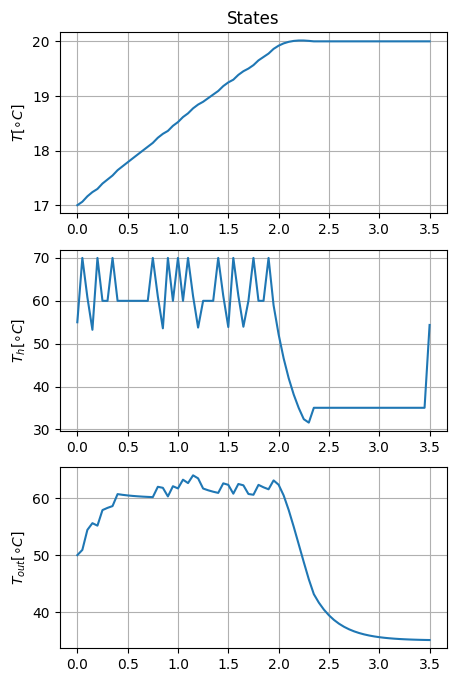

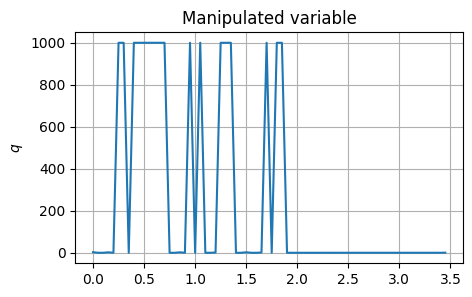

In [103]:
x_sol = sol.value(x)
u_sol = sol.value(u)

ts = np.arange(0, dt*(N+1), dt)

plt.figure(figsize=(5, 8))

plt.subplot(3, 1, 1)
plt.plot(ts, x_sol[0,:])
plt.ylabel(r'$T [\circ C]$')
plt.grid()
plt.title('States')

plt.subplot(3, 1, 2)
plt.plot(ts, x_sol[1,:])
plt.ylabel(r'$T_h [\circ C]$')
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(ts, x_sol[2,:])
plt.ylabel(r'$T_{out} [\circ C]$')
plt.grid()

plt.figure(figsize=(5, 3))
plt.plot(np.arange(0,dt*N, dt), u_sol)
plt.ylabel(r'$q$')
plt.grid()
plt.title('Manipulated variable')